In [1]:
import autograd.numpy as np
import autograd.scipy as sp
from autograd.scipy import special
from autograd import grad, hessian, hessian_vector_product, hessian, jacobian
import matplotlib.pyplot as plt
%matplotlib inline  

from copy import deepcopy

from scipy import optimize

import time

# Generate Data

In [2]:
# DP parameters
x_dim = 2
k_approx = 5
num_obs = 10

# prior parameters
alpha = 1 # DP parameter
mu_prior = np.zeros(x_dim)
info_mu_prior = 1 * np.eye(x_dim)

info_x = 1 * np.eye(x_dim)

# true means
mu_spacing = np.linspace(-10, 10, k_approx)
true_mu = np.array([ mu_spacing, mu_spacing]).T

# draw beta sticks
v = np.zeros(k_approx)
pi = np.zeros(k_approx)
stick_remain = np.zeros(k_approx)

v[0] = np.random.beta(1, alpha)
pi[0] = v[0]
stick_remain[0] = 1 - v[0]

for i in range(1, k_approx): 
    if i == k_approx - 1: # the last stick
        v[i] = 1.0
    else: 
        v[i] = np.random.beta(1, alpha)
    
    pi[i] = stick_remain[i - 1] * v[i]
    stick_remain[i] = stick_remain[i - 1] * (1 - v[i])
    

# draw group indicators
true_z = np.random.multinomial(1, pi, num_obs)
true_z_ind = np.full(num_obs, -1)
for row in np.argwhere(true_z):
    true_z_ind[row[0]] = row[1]
    
# draw observations
x = np.array([ np.random.multivariate_normal(
                true_mu[true_z_ind[n]], np.linalg.inv(info_x)) \
               for n in range(num_obs) ])

n_obs per component: 
 [1 5 2 1 1]
true mixture proportions: 
 [ 0.22987723  0.4844073   0.22957419  0.00971165  0.04642962]


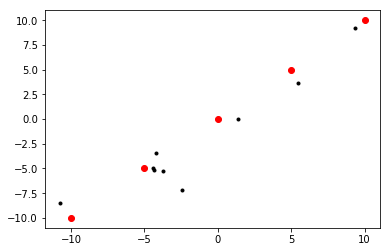

In [3]:
# visualize the data
plt.plot(x[:,0], x[:,1], 'k.')
for k in range(k_approx):
    plt.plot(true_mu[k, 0], true_mu[k, 1], 'ro')
    
print('n_obs per component: \n', np.sum(true_z, axis = 0))
print('true mixture proportions: \n', pi)

## Set up VB model

In [4]:
import sys
sys.path.append('../../LinearResponseVariationalBayes.py')

from VariationalBayes.ParameterDictionary import ModelParamsDict
from VariationalBayes.Parameters import ScalarParam, VectorParam, ArrayParam
from VariationalBayes.DirichletParams import DirichletParamArray
from VariationalBayes.MatrixParameters import PosDefMatrixParam, PosDefMatrixParamVector

In [5]:
vb_params = ModelParamsDict('vb_params')
vb_params.push_param(
    PosDefMatrixParamVector(name='info', length=k_approx, matrix_size=x_dim)) # variational variances
vb_params.push_param(
    ArrayParam(name='mu', shape=(k_approx, x_dim))) # variational means
vb_params.push_param(
    DirichletParamArray(name='v_sticks', shape=(k_approx, 2))) 
vb_params.push_param(
    ArrayParam(name='e_z', shape=(num_obs, k_approx), lb = 0.0, ub = 1.0))


In [6]:
vb_params['info'].get()

array([[[ 1.,  0.],
        [ 0.,  1.]],

       [[ 1.,  0.],
        [ 0.,  1.]],

       [[ 1.,  0.],
        [ 0.,  1.]],

       [[ 1.,  0.],
        [ 0.,  1.]],

       [[ 1.,  0.],
        [ 0.,  1.]]])

In [7]:
prior_params = ModelParamsDict('prior_params')
prior_params.push_param(VectorParam(name='mu_prior_mean', size=x_dim, val=mu_prior))
prior_params.push_param(PosDefMatrixParam(name='mu_prior_info', size=x_dim, val=info_mu_prior))
prior_params.push_param(ScalarParam(name='alpha', val=alpha))
prior_params.push_param(PosDefMatrixParam(name='info_x', size=x_dim, val=info_x))

## Define elbo

In [16]:
def normal_prior(mu, info, prior_info): 
    return np.sum(np.expand_dims(np.einsum('ki, kij, kj -> k', mu, info, mu), axis=0) + \
                      np.einsum('kii, ii -> k', info, prior_info)) # double check this at some point ...

def elbo(vb_params, prior_params): 
    e_log_1mv = vb_params['v_sticks'].e_log()[:,1] # E[log 1 - v]
    mu = vb_params['mu'].get()
    info = vb_params['info'].get()
    prior_info = prior_params['mu_prior_info'].get()

    dp_prior = np.sum(e_log1mv)
    normal_prior = normal_prior(mu, info, prior_info) ####
    
    # log likelihood of stick breaking process
    

In [17]:
mu = vb_params['mu'].get()
info = vb_params['info'].get()
prior_info = prior_params['mu_prior_info'].get()
normal_prior(mu, info, prior_info)

[[ 0.  0.  0.  0.  0.]]
[ 2.  2.  2.  2.  2.]


In [18]:
print(mu)
print(info)
print(prior_info)

[[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]
[[[ 1.  0.]
  [ 0.  1.]]

 [[ 1.  0.]
  [ 0.  1.]]

 [[ 1.  0.]
  [ 0.  1.]]

 [[ 1.  0.]
  [ 0.  1.]]

 [[ 1.  0.]
  [ 0.  1.]]]
[[ 1.  0.]
 [ 0.  1.]]
